## Pseodocode for Spectral Clustering

1. Input the dataset of $R^{N\times D}$ and $K$ (number of clusters) as arguments.
2. Compute the adjacency matrix with the dataset.
3. Calculate the degree matrix (D) for unnormalized clustering computation.
4. Calculate the laplasian and do the eigen value decomposion.
5. Select the 'K' lowest eigen vectors based on their respective eigen values.
6. Do Kmeans on those eigen vectors as observation.
7. Assign the extracted labels from Kmeans to original data


## Spectral Clustering Code
### Library Files

In [1]:
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import lil_matrix

### Kmeans Code

In [2]:
def initialize(X,K):
    centers = X[random.sample(range(0,(X.shape[0]-1)),K)]
    return centers

def assignment(X, centers):
    indx = []
    for point in X:
        norm = np.linalg.norm((centers-point), axis =1)
        indx.append(np.argmin(norm))
    return indx

def updateCenters(X,K,indx):
    newCenters = []
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        centroid = Cluster.mean(axis=0)
        newCenters.append(centroid)
    return newCenters

def AvgScore(X,K,indx,centers):
    score = []
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        distanceList = np.linalg.norm((Cluster-centers[clusterNumber]), axis =1)
        score.append(np.mean(distanceList))
            
    return score

def DisplayPlot(X,K,centers,indx):
    colors = ['green', 'purple', 'yellow', 'red', 'orange', 'plum', 'navy', 'seagreen', 'pink', 'brown']
    for clusterNumber in range(0,K):
        Cluster = X[[i for i, find in enumerate(indx) if find == clusterNumber]]
        plt.scatter(Cluster[:,0],Cluster[:,1], marker='.' ,color=colors[clusterNumber])
        plt.scatter(np.array(centers)[clusterNumber,0],np.array(centers)[clusterNumber,1], marker='+' ,color='black')    
    plt.show()

def Kmeans(X,K,tol=0.0001,plot=False,stat=False):
    X = np.array(X)
    centers = initialize(X,K)
    indx = assignment(X, centers)
    AvgScore(X,K,indx,centers)
    Distortion = 1
    while Distortion > tol:
        newCenters = updateCenters(X,K,indx)
        newIndx = assignment(X, newCenters)
        
        scoreOld = AvgScore(X,K,indx,centers)
        scoreNew = AvgScore(X,K,newIndx,newCenters)
        
        Distortion = np.linalg.norm((np.array(scoreOld) - np.array(scoreNew)), axis =0)
        centers = newCenters
        indx = newIndx
        if stat:
            print('Score Old:',scoreOld,'\n')
            print('Score new:',scoreNew,'\n')
            print('Distortion:', Distortion)
            print('---------------------')
        
    if plot:
        DisplayPlot(X,K,centers,indx)
        
    return centers, indx, scoreNew

### Spectral Clustering Code

In [3]:
def adj_generate(X,gamma):
    n=X.shape[0]
    a=np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            a[i,j] = math.exp(-math.pow(np.linalg.norm((X[i]-X[j]),2),2) * gamma)
    return a

In [13]:
def construct_W(X, Wtemp, k_neighbors):
    scores_matrix = lil_matrix(Wtemp)
    # knn_matrix is a sparse matrix
    knn_matrix = kneighbors_graph(X, k_neighbors, mode='connectivity', include_self=True)
    W = knn_matrix.multiply(scores_matrix)  # pointwise multiply

    return W.toarray()

In [23]:
def spectralClustering(X,K,gamma,normalised=False):
    X = np.array(X)
    A = adj_generate(X,gamma)
    W = construct_W(X,A,20)
    if normalised:
        D12 = np.diag(np.sum(W,axis=1)**(-0.5))
        L = np.identity(X.shape[0]) - D12@W@D12
        w, v = np.linalg.eig(L)
        sorted_index = np.argsort(np.real(w))
        #print(sorted_index)
        v=np.array(np.real(v))
        Y = v[:,sorted_index[0:K]]
        for x in range(Y.shape[0]):
            Y[x] = Y[x] / np.linalg.norm(Y[x])
    else: 
        D = np.diag(np.sum(W,axis=1))
        L = D - W
        w, v = np.linalg.eig(L)
        sorted_index = np.argsort(w)
        v=np.array(v)
        Y = v[:,sorted_index[0:K]]
    
    
    #print(W)
    return Y    

### Note:
we have performed unnormalised clustering for dataset1. For dataset 2, both normalized and unnormalised clustering have been performed.

## Dataset1 Analysis

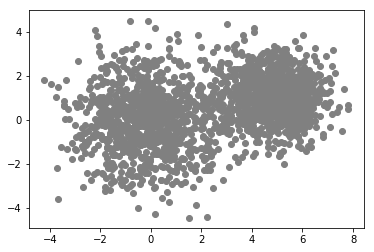

In [10]:
data = pd.read_csv('clustering.csv', header=None)
plt.scatter(data[0],data[1], color='grey')
plt.show()

### Spectral Clustering Implementation

#### Test Run: K= 2
The sigma value chosen is 0.5

C:\Users\Naman\Anaconda3\lib\site-packages\numpy\core\numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


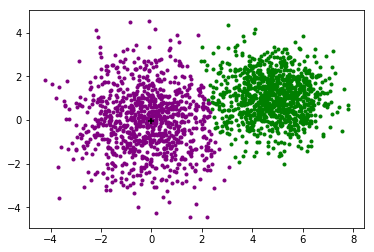

In [15]:
Y = spectralClustering(data,2,1)
centers, indx, score = Kmeans(Y,2)
DisplayPlot(np.array(data),2,centers,indx)

### Observation:
The dataset is clustered quite well with spectral unnormalised clustering. The K means is still the best for this kind of data because of the computational time. Detailed analysis on score value (D value) is done in the later section.

## Dataset 2 Analysis

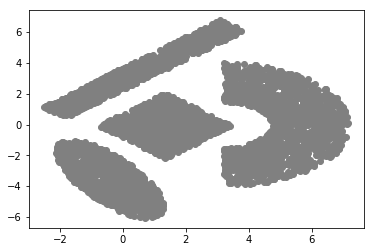

In [16]:
data = pd.read_csv('ShapedData.csv', header=None)
plt.scatter(data[0],data[1], color='grey')
plt.show()

### Spectral Clustering Implementation (Without the Use of KNN)

#### Test Run: K= 4
The sigma value choosen is 0.5 (Unnormalized)

[ 0  1  2 ..., 16 15 14]


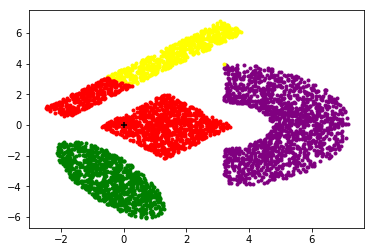

In [60]:
Y = spectralClustering(data,4,1)
centers, indx, score = Kmeans(Y,4)
DisplayPlot(np.array(data),4,centers,indx)

### Observation:
The dataset is clustered quite well but still some sections are not yet clustered properly. Hence, we need to go for normalised clustering. By tweeking the sigma value the concentraion of red portion in the above plot changes but still remains in two different portions.

#### Test Run: K= 4
The sigma value choosen is 0.701 (Normalized)
Note: Subset of datapoints have been choosen for time efficiency in order to choose correct value of sigma.

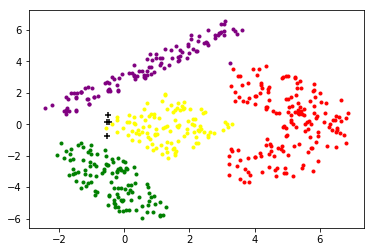

In [63]:
Y = spectralClustering(np.array(data)[0:500],4,1,True)
centers, indx, score = Kmeans(Y,4)
DisplayPlot(np.array(data)[0:500],4,centers,indx)

### Observation:
The reduced datacets indicates the perfect clustering. Now, spectral clustering is done on entire dataset for same value of sigma and with normalized clustering.

#### Final Run: K= 4
The sigma value choosen is 0.701 (Normalized)
Note: Entire Dataset

C:\Users\Naman\Anaconda3\lib\site-packages\numpy\core\numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


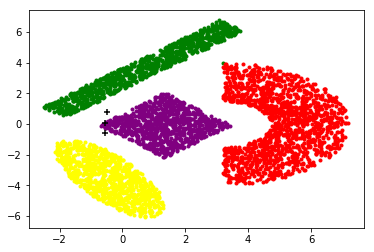

In [64]:
Y = spectralClustering(np.array(data),4,1, True)
centers, indx, score = Kmeans(Y,4)
DisplayPlot(np.array(data),4,centers,indx)

### Spectral Clustering (With KNN [20 nearest neighbor])

#### Test Run: K= 4
The sigma value choosen is 0.5 (Unnormalized)

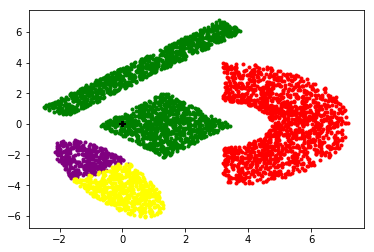

In [19]:
Y = spectralClustering(data,4,1)
centers, indx, score = Kmeans(Y,4)
DisplayPlot(np.array(data),4,centers,indx)

C:\Users\Naman\Anaconda3\lib\site-packages\numpy\core\numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


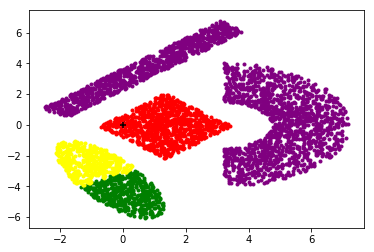

In [24]:
Y = spectralClustering(data,4,0.5)
centers, indx, score = Kmeans(Y,4)
DisplayPlot(np.array(data),4,centers,indx)

## Dicussion
- The spectral clustering takes into account the relationship between the points and creates a weighted graph. This information helps the classifier to classify and assign the clusters properly. 
- We are also able to figure out the expected number of clusters based on the lowest eigen values.
- The spectral clustering function is extreamly imefficient as far as time complexity is concerened.

# Overall Score Comparison: K means and Spectral Clustering

### Dataset 1 Distance Metric 

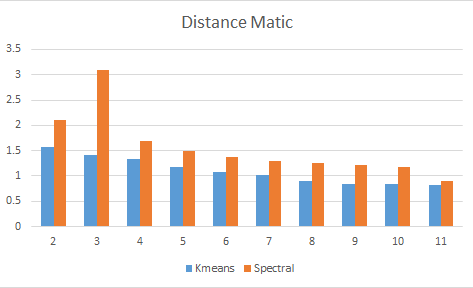

In [1]:
from IPython.display import Image
Image("DMdata1.png")

### Observation: 

The objective function values are constantly decreasing in both the case (with K=3 as an outlier for spectral clustering). The distance values in spectral clustering case is not a physical distortion value but the distortion observerd in K dimension space. Comparing in between Kmeans and Spectral clustering, the values for spectral is always higher but started to converge at the saturation region.

### Dataset 2 Distance Metric 

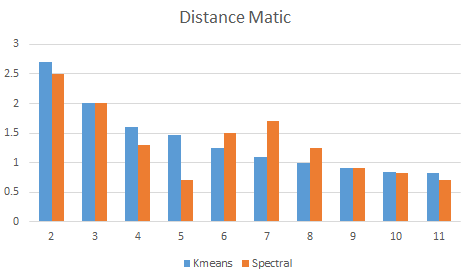

In [2]:
from IPython.display import Image
Image("DMdata2.png")

### Observation: 

The objective values is actual discriptive of the spectral clustering result. For Kmeans the treand is similar in both the datasets because no additional information is available during clustering. But spectral clustering have wave like pattern with lowest at 5 and 11. This is very close of pridicting actual number of observable custer i.e. 4. Hence, the connected graph with adjacency matrix provides information about choosing number of clusters.

# Overall Comments:

- Computational running time for Kmeans is observed to be the least (depending upon convergence criteria) and for Spectral clustering the highest.
- Kmeans works better when the data is randomely distributed and have no inherent correlation between datapoints.
- Limitations are present in Kmeans and Greedy K centers with initializations.
- Greedy K Centers algorithm is independent on convergence. Hence, definite order or dunning time [O(NK)]
- Single Swap methods clears the initialization limitation.
- Single Swap have exponential order of running time. (Due to n Choose k)
- Spectral clustering works better with datasets which have inherent correlations, for example Dataset2.
- One limitation of Spectral Clustering is the approximation of coordinates center.
- Finally, there is a huge difference between obtained results if we choose optimal sigma value and do normalized clustering